In [72]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from scipy.stats import ttest_1samp
%matplotlib inline

In [2]:
valid_pred = pd.read_hdf('../../_data/20170718-003045-b2-albu-eval.h5')
valid_pred[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
b'image_name',,,,,,,,,,,,,,,,,
train_0,0.002900,0.001370,0.001533,0.001599,0.001442,0.733193,0.001396,0.001365,0.002094,0.001792,0.828538,0.001803,0.998538,0.001924,0.001486,0.001427,0.003176
train_1,0.893066,0.002227,0.009441,0.001569,0.001566,0.998100,0.001370,0.001451,0.642272,0.023163,0.001569,0.001671,0.998555,0.704373,0.002417,0.009954,0.883210
train_2,0.002361,0.001377,0.001498,0.001468,0.001442,0.998310,0.001365,0.001356,0.001742,0.001737,0.001508,0.001479,0.998572,0.001655,0.001452,0.001411,0.001930


In [9]:
train_flat = pd.read_csv('../../_data/train_flat.csv', index_col=0)
train_flat[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
image_name,,,,,,,,,,,,,,,,,
train_0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
train_1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
train_2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [18]:
def f2_score(y_true, y_pred, eps=1e-7) -> float:
    # same as fbeta_score(y_true, y_pred, beta=2, average='samples')
    # but faster
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.as_matrix()
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.as_matrix()
    tp = (y_true * y_pred).sum(axis=1)
    r = tp / y_true.sum(axis=1)
    p = tp / (y_pred.sum(axis=1) + eps)
    beta2 = 4
    f2 = (1 + beta2) * p * r / (beta2 * p + r + eps)
    return f2.mean()

In [19]:
threshold = 0.2
original_score = f2_score(train_flat, valid_pred > threshold)
original_score

0.93320946748926459

In [ ]:
for th in np.linspace(0.15, 0.35, 100):
    score = f2_score(train_flat.as_matrix(), (valid_pred > th).as_matrix())
    if score > original_score:
        print('{:.4f} {:.7f}'.format(th, score - original_score))

Mean delta +0.00010
T-test: Ttest_1sampResult(statistic=1.9254977191996936, pvalue=0.054450719519534577)


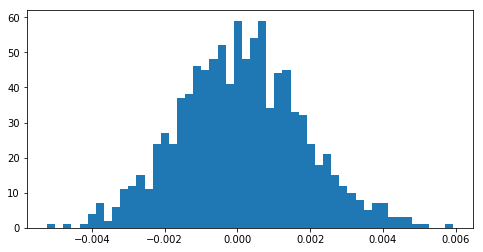

In [102]:
deltas = []
for _ in range(100):
    for train_ids, valid_ids in KFold(n_splits=10, shuffle=True).split(valid_pred.index):
        hack = valid_pred.iloc[valid_ids].copy()
        hack[hack['cloudy'] > .7] *= .7
        delta = f2_score(train_flat.iloc[valid_ids], hack > threshold) - original_score
        deltas.append(delta)
        # print('{:+.5f}'.format(delta))
plt.figure(figsize=(8, 4))
plt.hist(deltas, bins=50);
print('Mean delta {:+.5f}'.format(np.mean(deltas)))
print('T-test: {}'.format(ttest_1samp(deltas, 0)))

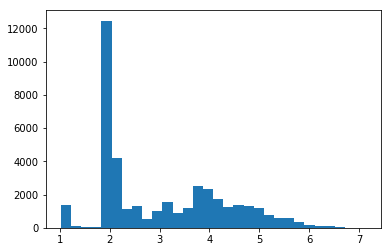

In [37]:
plt.hist(hack.as_matrix().sum(axis=1), bins=30);